In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import pickle
from utils import load_data
from scipy.sparse import coo_matrix
import seaborn as sns
import dgl
import tqdm
from itertools import combinations

Using backend: pytorch


In [2]:
browsing, search, sku, info = load_data('../dataset/new/')

load browsing done...
load search done...
load sku done...
load info done...


In [3]:
browsing = browsing[browsing['product_action'] != 4]

In [4]:
browsing.dropna(inplace=True)
browsing['product_sku_hash'] = browsing['product_sku_hash'].astype(int)

In [5]:
browsing

session_id_hash  product_action  product_sku_hash  \
train 0                      0               0             31231   
      1                      0               0             30494   
      3                      0               0             31231   
      7                      0               0             31231   
      16                     0               0             16827   
...                        ...             ...               ...   
test  1303283          5408427               0             49638   
      1303284          5408427               0             57027   
      1303285          5408427               0             30346   
      1303286          5408427               0             41265   
      1303287          5408428               0             57976   

               server_timestamp_epoch_ms  hashed_url  
train 0                    1550885210881           0  
      1                    1550885213307           1  
      3                    1550885215484           0  
      7                    1550885304014           0  
      16                   1550885885435           9  
...                                  ...         ...  
test  1303283              1557369241429        4838  
      1303284              1557369275425         956  
      1303285              1557369282615         958  
      1303286              1557369290441        2830  
      1303287              1555935443983        9423  

[10920461 rows x 5 columns]

In [8]:
sesses = browsing.groupby(['session_id_hash'])['product_sku_hash'].agg(list)

In [82]:
list(combinations([2,4,3], 2))

[(2, 4), (2, 3), (4, 3)]

In [18]:
sesses = sesses.reset_index()

In [66]:
all_pairs = []
for sess_id, sku_ids in tqdm.tqdm(sesses.values):
    all_pairs.extend(list(combinations(sku_ids, 2)))

100%|██████████| 3599278/3599278 [00:14<00:00, 246728.76it/s]


In [67]:
df = pd.DataFrame(all_pairs)
df.columns = ['src_id', 'dst_id']
df = df.groupby(['src_id', 'dst_id']).size().reset_index()
df.columns = ['src_id', 'dst_id', 'weight']
df['mask'] = (df['src_id'] != df['dst_id'])
df = df[df['mask']].copy()

In [68]:
df.drop(columns=['mask'], inplace=True)

src_id
2        397
3        212
4        311
7         61
10       153
        ... 
66371     20
66375     13
66376    303
66378     15
66383     30
Name: dst_id, Length: 30551, dtype: int64

In [88]:
df['src_id'].nunique(), df['dst_id'].nunique()

(30551, 30603)

In [91]:
all_ids = set(df['src_id'].unique()) | set(df['dst_id'].unique())

In [92]:
len(all_ids)

30824

In [84]:
df.shape

(6928143, 3)

In [78]:
df.to_csv('../dataset/prepared/i-i.txt', index=False, header=False, sep=' ')

# Build Embedding

In [3]:
with open('deepwalk/i-i.embed', 'r') as f:
    line = f.readline()
    embedding = torch.zeros(66386, 128)
    for line in tqdm.tqdm(f):
        line = line.split(' ')
        node_id  = int(line[0])
        node_vec = list(map(float, line[1:]))
        embedding[node_id] = torch.tensor(node_vec)

30824it [00:01, 20483.95it/s]


In [4]:
embedding = F.normalize(embedding, dim=1)
with open('../dataset/prepared/dw_sku_i-i.pkl', 'wb') as f:
    pickle.dump(embedding.numpy(), f)

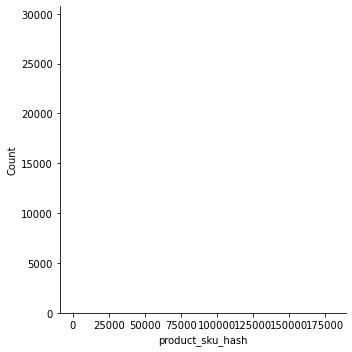

In [5]:
sns.displot(browsing.groupby('product_sku_hash')['product_sku_hash'].count())